<a href="https://colab.research.google.com/github/Aniket-Walimbe/Aniket_Walimbe_ISE535_Project/blob/main/Project_Aniket_Walimbe_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import csv
import seaborn as sb
import itertools
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go
from keras.layers import Dense
from keras.models import Sequential

from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import tensorflow as tf
import plotly.offline as pyoff
import plotly.graph_objs as go


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install chart-studio

In [ ]:
from chart_studio import plotly


In [ ]:
#
df_csv = pd.read_csv("/content/Historical Product Demand.csv")
df_csv

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


In [ ]:
df_csv = df_csv.dropna(axis=0)
df_csv.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [ ]:
df_csv['Order_Demand'] = df_csv['Order_Demand'].str.replace('(','', regex=True)
df_csv['Order_Demand'] = df_csv['Order_Demand'].str.replace(')','', regex=True)
df_csv['Order_Demand'] = df_csv['Order_Demand'].replace(' ','', regex=True)
df_csv['Order_Demand'] = df_csv['Order_Demand'].apply(lambda x : int(x))
df_csv

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


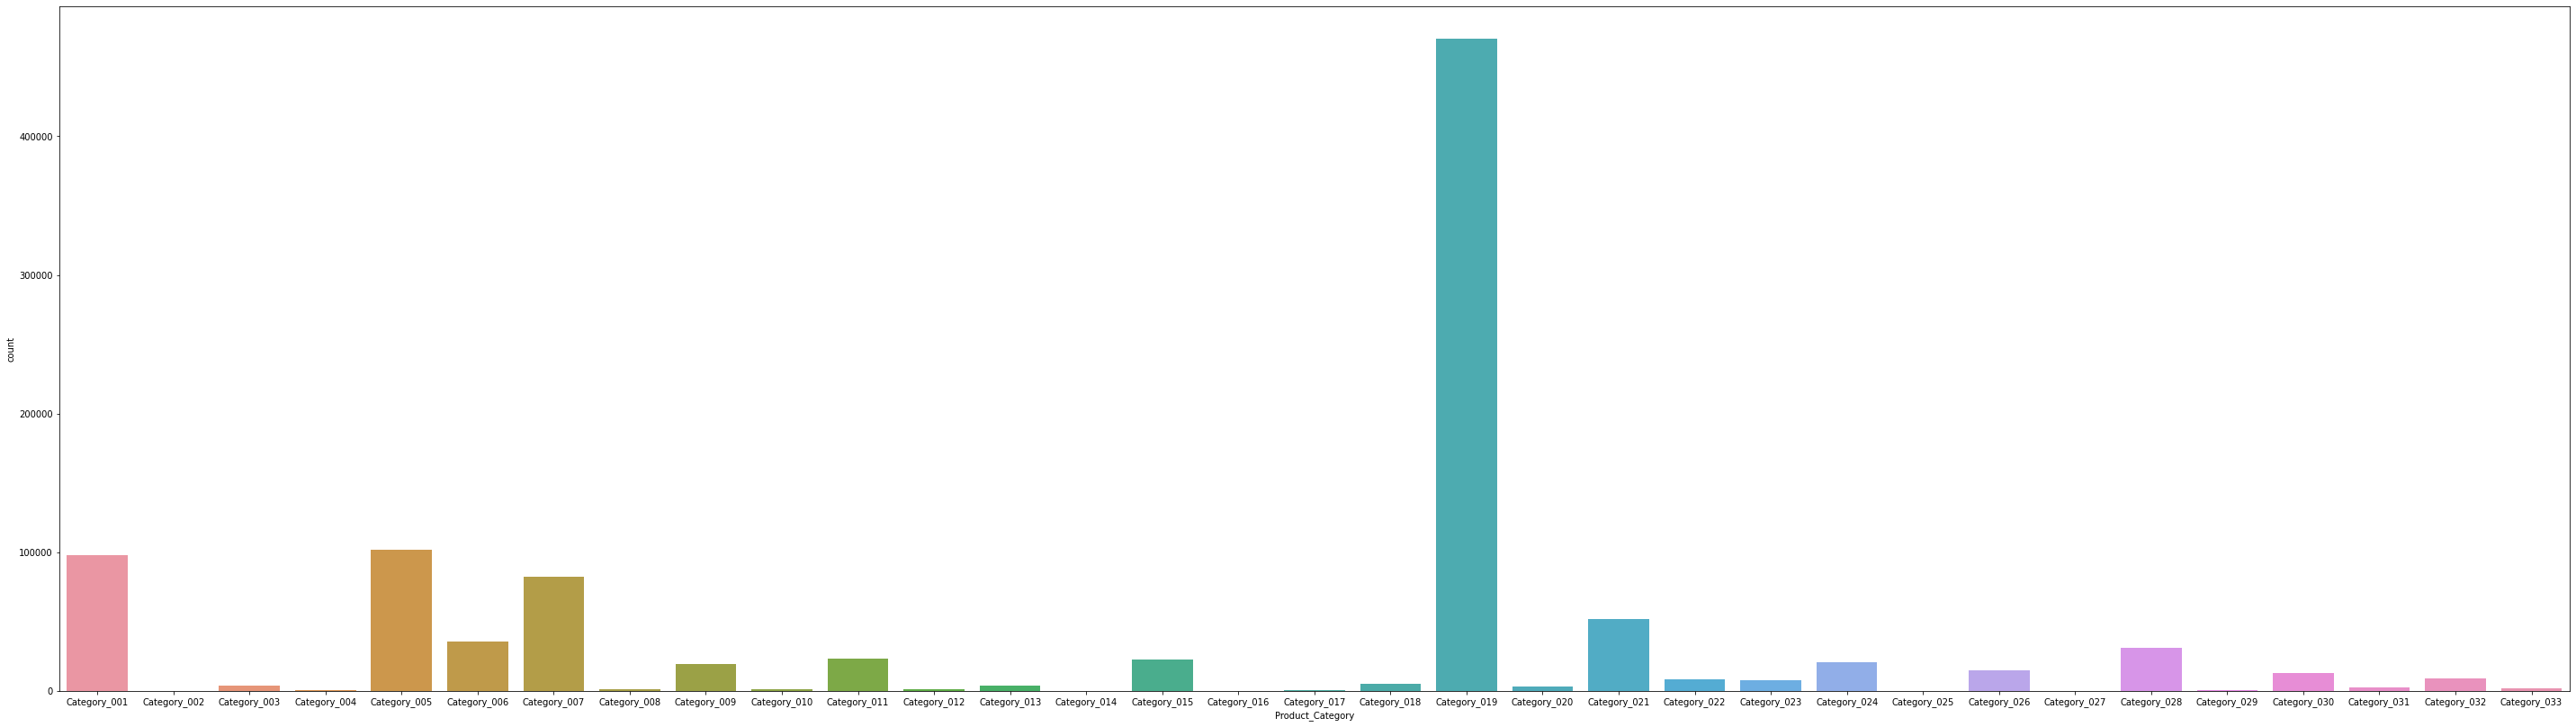

In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 50,14
sb.countplot(df_csv['Product_Category'].sort_values(ascending = True))

In [ ]:
df_csv = df_csv[(df_csv['Date']>='2012-01-01') & (df_csv['Date']<='2017-1-9')].sort_values('Date', ascending=True)
df_csv.groupby('Warehouse')['Order_Demand'].sum().sort_values(ascending=False)
df_csvfinal = pd.DataFrame(df_csv.groupby('Product_Category')['Order_Demand'].sum().sort_values(ascending=False))
df_csvfinal["% Contribution"] = df_csvfinal['Order_Demand']/df_csvfinal['Order_Demand'].sum()*100
df_finalData = df_csvfinal.head()
df_finalData

,Order_Demand,% Contribution
Product_Category,,
Category_019,4233421162,82.595039
Category_006,405010821,7.901856
Category_005,198990170,3.882345
Category_007,128660495,2.510196
Category_028,48938528,0.954802


In [ ]:
df_csv_cat1 = df_csv.loc[(df_csv['Product_Category']=='Category_019')]
df_csv_cat1.groupby(['Product_Category'])[['Order_Demand']].sum()
df_csv_cat1

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
63102,Product_1451,Whse_J,Category_019,2012/1/10,5000
63104,Product_1274,Whse_J,Category_019,2012/1/10,5000
63105,Product_1359,Whse_J,Category_019,2012/1/10,5000
63098,Product_1451,Whse_J,Category_019,2012/1/10,6000
40537,Product_1244,Whse_J,Category_019,2012/1/10,2000
...,...,...,...,...,...
946505,Product_1540,Whse_J,Category_019,2016/9/9,1000
1008069,Product_1213,Whse_J,Category_019,2016/9/9,100
1034303,Product_1359,Whse_J,Category_019,2016/9/9,1000
967074,Product_0409,Whse_J,Category_019,2016/9/9,20


In [ ]:
df_csv_cat1.Date = pd.to_datetime(df_csv_cat1.Date, dayfirst=True)
df1 = df_csv_cat1.resample('m', on='Date')['Order_Demand'].sum().dropna()
df1 = df1.to_frame()
df1.reset_index(inplace=True)
df1

,Date,Order_Demand
0,2012-01-31,61243661
1,2012-02-29,72219508
2,2012-03-31,72444888
3,2012-04-30,61382420
4,2012-05-31,72041920
5,2012-06-30,69699151
6,2012-07-31,75524796
7,2012-08-31,61371824
8,2012-09-30,52363457
9,2012-10-31,69864828


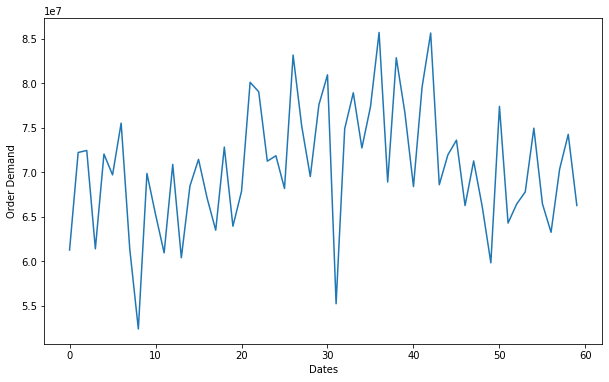

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Order Demand')
plt.plot(df1.Order_Demand)
plt.show()

In [ ]:
#create a new dataframe to model the difference
df_diff = df1.copy()
#add previous demand to the next row
df_diff['prev_demand'] = df_diff['Order_Demand'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['Order_Demand'] - df_diff['prev_demand'])
df_diff.head(10)

,Date,Order_Demand,prev_demand,diff
1,2012-02-29,72219508,61243661.0,10975847.0
2,2012-03-31,72444888,72219508.0,225380.0
3,2012-04-30,61382420,72444888.0,-11062468.0
4,2012-05-31,72041920,61382420.0,10659500.0
5,2012-06-30,69699151,72041920.0,-2342769.0
6,2012-07-31,75524796,69699151.0,5825645.0
7,2012-08-31,61371824,75524796.0,-14152972.0
8,2012-09-30,52363457,61371824.0,-9008367.0
9,2012-10-31,69864828,52363457.0,17501371.0
10,2012-11-30,65250687,69864828.0,-4614141.0


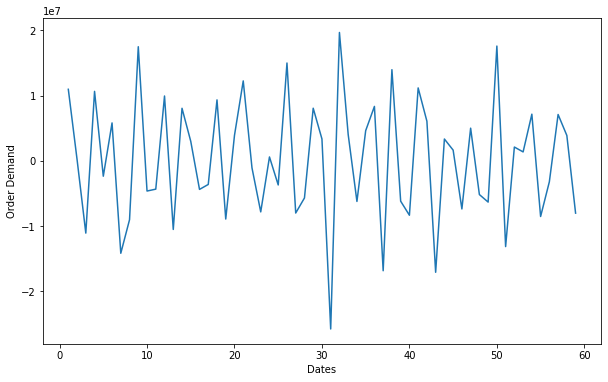

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Order Demand')
plt.plot(df_diff['diff'])
plt.show()

In [ ]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_demand'],axis=1)
#adding lags
for inc in range(1, 13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)
df_supervised.head()

,Date,Order_Demand,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2013-02-28,60376821,-10500652.0,9951316.0,-4324530.0,-4614141.0,17501371.0,-9008367.0,-14152972.0,5825645.0,-2342769.0,10659500.0,-11062468.0,225380.0,10975847.0
1,2013-03-31,68444323,8067502.0,-10500652.0,9951316.0,-4324530.0,-4614141.0,17501371.0,-9008367.0,-14152972.0,5825645.0,-2342769.0,10659500.0,-11062468.0,225380.0
2,2013-04-30,71445203,3000880.0,8067502.0,-10500652.0,9951316.0,-4324530.0,-4614141.0,17501371.0,-9008367.0,-14152972.0,5825645.0,-2342769.0,10659500.0,-11062468.0
3,2013-05-31,67082121,-4363082.0,3000880.0,8067502.0,-10500652.0,9951316.0,-4324530.0,-4614141.0,17501371.0,-9008367.0,-14152972.0,5825645.0,-2342769.0,10659500.0
4,2013-06-30,63476196,-3605925.0,-4363082.0,3000880.0,8067502.0,-10500652.0,9951316.0,-4324530.0,-4614141.0,17501371.0,-9008367.0,-14152972.0,5825645.0,-2342769.0


In [ ]:
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [ ]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.21226255997596166


In [ ]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5+ lag_6 + lag_7 ', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.5867999470311545


In [ ]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.5928929329993277


In [ ]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['Order_Demand','Date'],axis=1)
#df_model.head()
#split train and test set
train_set, test_set = df_model[0:12].values, df_model[12:].values
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [ ]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1,shuffle=False)

Epoch 1/100
12/12 [==============================] - 2s 3ms/step - loss: 0.4421
Epoch 2/100
12/12 [==============================] - 0s 2ms/step - loss: 0.4399
Epoch 3/100
12/12 [==============================] - 0s 2ms/step - loss: 0.4335
Epoch 4/100
12/12 [==============================] - 0s 2ms/step - loss: 0.4237
Epoch 5/100
12/12 [==============================] - 0s 2ms/step - loss: 0.4139
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 0.4044
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 0.3954
Epoch 8/100
12/12 [==============================] - 0s 3ms/step - loss: 0.3867
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.3784
Epoch 10/100
12/12 [==============================] - 0s 2ms/step - loss: 0.3703
Epoch 11/100
12/12 [==============================] - 0s 2ms/step - loss: 0.3624
Epoch 12/100
12/12 [==============================] - 0s 3ms/step - loss: 0.3547
Epoch 13/100
12/12 [=================

In [ ]:
y_pred = model.predict(X_test,batch_size=1)

In [ ]:
#reshape y_pred 
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print (np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

[[-0.63666111 -0.02397919 -0.76366555 -0.17064475  0.62592017  0.03033149
  -0.66849844  0.48530519 -0.33361138 -0.38145044  0.08382297  0.40394473
  -0.76923735]]
[[ 0.16851556 -0.40101554 -0.02397919 -0.76366555 -0.32576728  0.62592017
   0.14221312 -0.66849844  0.48530519 -0.33361138 -0.38145044  0.08382297
   0.40394473]]
[[ 0.39599943  1.2409056  -0.40101554 -0.02397919 -0.80786952 -0.32576728
   0.669082    0.14221312 -0.66849844  0.48530519 -0.33361138 -0.38145044
   0.08382297]]
[[ 0.09431796 -0.77895267  1.2409056  -0.40101554 -0.20653404 -0.80786952
  -0.1727985   0.669082    0.14221312 -0.66849844  0.48530519 -0.33361138
  -0.38145044]]
[[-0.11331368 -0.5763138  -0.77895267  1.2409056  -0.51304954 -0.20653404
  -0.59927515 -0.1727985   0.669082    0.14221312 -0.66849844  0.48530519
  -0.33361138]]
[[-0.28892046  0.63220259 -0.5763138  -0.77895267  0.82176681 -0.51304954
  -0.06732255 -0.59927515 -0.1727985   0.669082    0.14221312 -0.66849844
   0.48530519]]
[[-0.40079868  0

In [ ]:
#create dataframe that shows the predicted demand
result_list = []
order_dates = list(df1[13:].Date)
act_demand = list(df1[13:].Order_Demand)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_demand[index])
    result_dict['Date'] = order_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
df_result
#for multistep prediction, replace act_demand with the predicted demand

,pred_value,Date
0,54011787,2013-03-31
1,71244023,2013-04-30
2,76834184,2013-05-31
3,69037284,2013-06-30
4,63068041,2013-07-31
5,70424446,2013-08-31
6,60244779,2013-09-30
7,70711835,2013-10-31
8,81944090,2013-11-30
9,82995087,2013-12-31


In [ ]:
df_demand_pred = pd.merge(df1,df_result,on='Date',how='left')
df_demand_pred

,Date,Order_Demand,pred_value
0,2012-01-31,61243661,NaN
1,2012-02-29,72219508,NaN
2,2012-03-31,72444888,NaN
3,2012-04-30,61382420,NaN
4,2012-05-31,72041920,NaN
5,2012-06-30,69699151,NaN
6,2012-07-31,75524796,NaN
7,2012-08-31,61371824,NaN
8,2012-09-30,52363457,NaN
9,2012-10-31,69864828,NaN


In [ ]:
#merge with actual demand dataframe
df_demand_pred = pd.merge(df1,df_result,on='Date',how='left')
#plot actual and predicted
plot_data = [
    go.Scatter(
        x=df_demand_pred['Date'],
        y=df_demand_pred['Order_Demand'],
        name='actual'
    ),
        go.Scatter(
        x=df_demand_pred['Date'],
        y=df_demand_pred['pred_value'],
        name='predicted'
    )
    
]
plot_layout = go.Layout(
        title='Demand Prediction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)